In [2]:
import pandas as pd
import os.path
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
df = pd.read_csv('../data/250204-mig-chuc-4xA100-burn180.csv')
df.reset_index(inplace=True)

drop_everything_before_measure = 'MIG_1g.5gb|1g.5gb|idle'

timestamp_decrease = df.timestamp.diff() < 0
restart = timestamp_decrease[timestamp_decrease].index.values
range_start = df.loc[df['measure'] == drop_everything_before_measure].iloc[0].values[0].astype(int)
frames = []
for range_end in restart:
    if range_start>0:
        frames.append(df[range_start:range_end].pivot(index=['timestamp','domain'], columns='metric', values='measure').reset_index())
    range_start = range_end
frames.append(df[range_start:].pivot(index=['timestamp','domain'], columns='metric', values='measure').reset_index())

dataset = pd.concat(frames)
dataset.set_index(['timestamp','domain', 'CONST_context'], inplace=True)
dataset_keys = list(dataset.keys())
if 'SMI_PSTATE' in dataset_keys: dataset_keys.remove('SMI_PSTATE')
if 'SMI_pstate' in dataset_keys: dataset_keys.remove('SMI_pstate')
dataset = dataset.astype({key:'float' for key in dataset_keys})
dataset.reset_index(inplace=True)

/tmp/ipykernel_73597/1718931181.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset.reset_index(inplace=True)
/tmp/ipykernel_73597/1718931181.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset.reset_index(inplace=True)
/tmp/ipykernel_73597/1718931181.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfr

In [29]:
dataset_domain = dataset.drop(dataset.loc[dataset['domain'].isin(['GPU-X', 'global'])].index)
dataset_domain = dataset_domain.join(dataset_domain['CONST_context'].str.split('|', expand=True).rename(columns={0:'GI', 1:'CI', 2:'noise'}))
dataset_domain['wrk'] = dataset_domain['noise'].apply(lambda x: 0 if x == 'idle' else int(x) + 1)
dataset_domain['compute'] = dataset_domain.apply(lambda x: 0 if x['noise'] == 'idle' else (int(x['noise']) + int(re.match(r"^\d+", x['CI']).group())),  axis=1)
dataset_domain = dataset_domain.drop(dataset_domain.loc[dataset_domain['timestamp'] > 180 ].index)
dataset_domain = dataset_domain.drop(dataset_domain.loc[dataset_domain['timestamp'] < 30 ].index)
dataset_domain_pure = dataset_domain.drop(dataset_domain[dataset_domain.CI.str.contains("c.")].index)
dataset_domain['GI'].unique()
#list(dataset_domain.keys())

array(['MIG_1g.5gb', 'MIG_1g.10gb', 'MIG_2g.10gb', 'MIG_3g.20gb',
       'MIG_4g.20gb', 'MIG_7g.40gb'], dtype=object)

# Graph time A100

In [5]:
sns.color_palette("Set2")
sns.set_theme(style="darkgrid")

In [31]:
#sns.catplot(data=dataset_domain_pure, x='timestamp', y='SMI_power.draw', hue='domain', col='CONST_context', col_wrap=7)

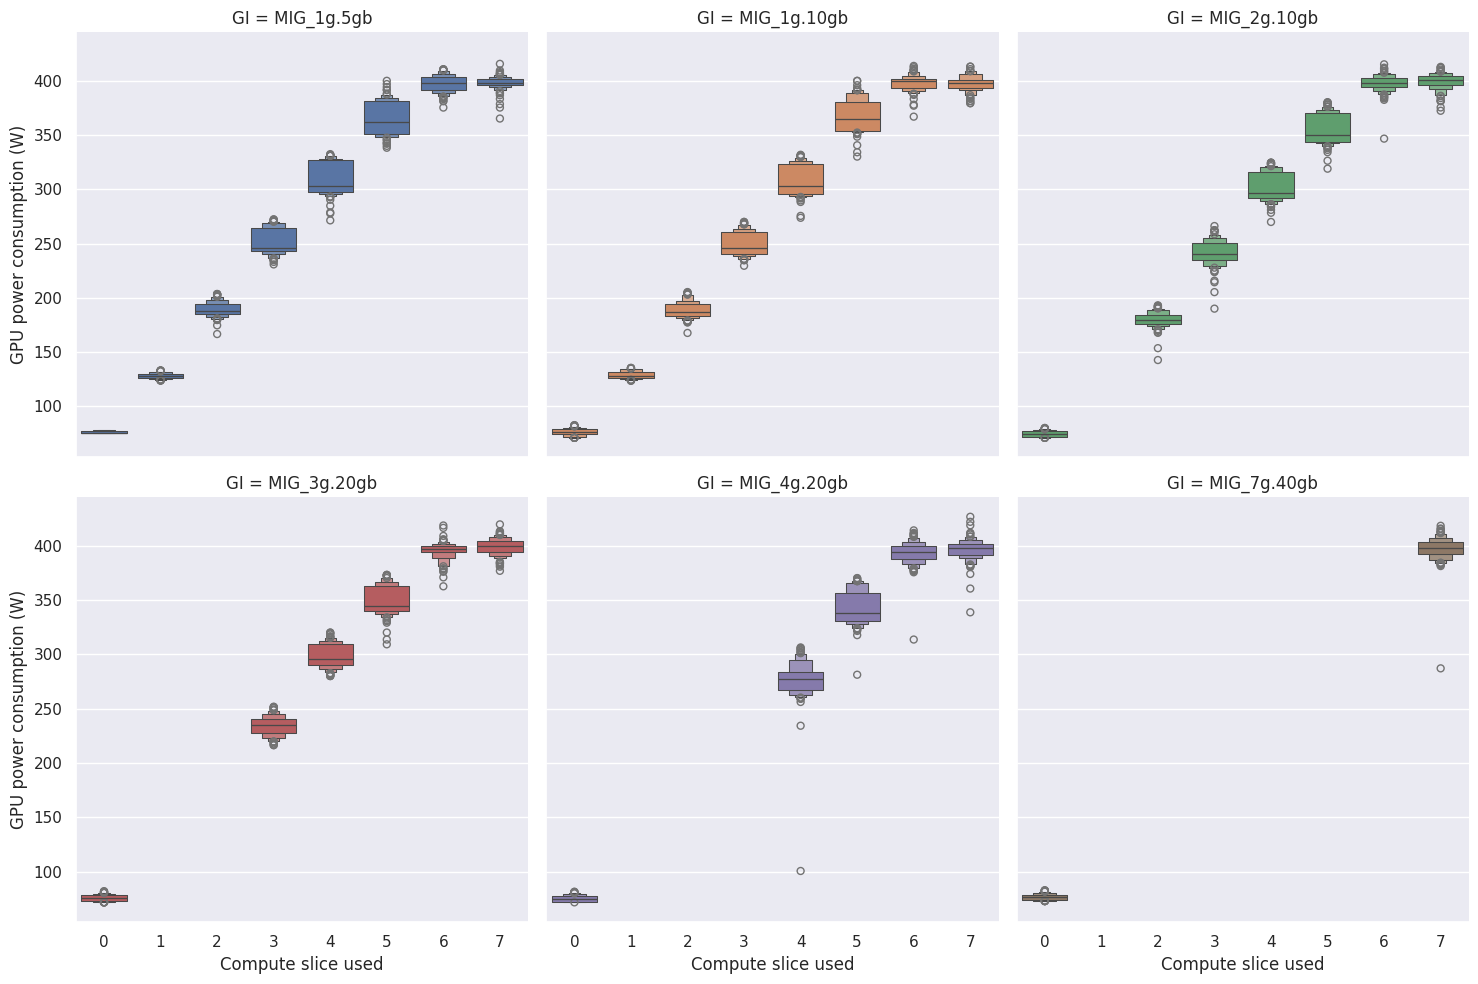

In [7]:
#sns.catplot(data=dataset_domain, x='timestamp', y='SMI_power.draw', hue='domain', col='CONST_context', col_wrap=7)
g = sns.catplot(data=dataset_domain_pure, x='compute', y='SMI_power.draw', hue='CI', kind="boxen", col='GI', col_wrap=3, sharey=True)
g.set_axis_labels("Compute slice used", "GPU power consumption (W)")
g.legend.remove()
plt.gcf().savefig('figures/MIG-GI-power-A100.pdf', bbox_inches='tight')

GI power consumption are linear compared to their used slices

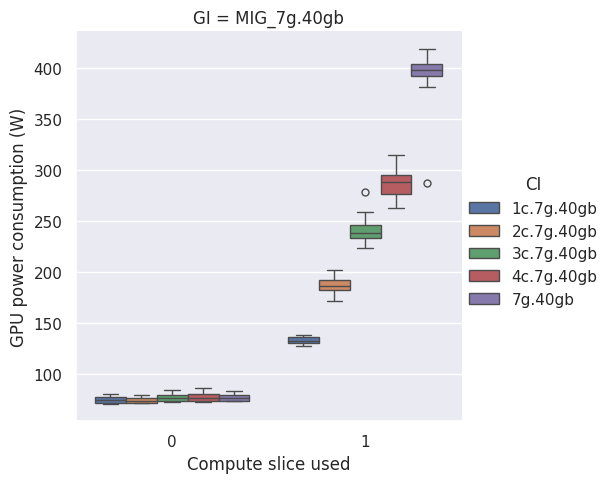

In [8]:
gi_label = 'MIG_7g.40gb'

gi_df = dataset_domain.loc[dataset_domain['GI'] == gi_label]

g = sns.catplot(data=gi_df, x='wrk', y='SMI_power.draw', col='GI', hue='CI', kind='box')
g.set_axis_labels("Compute slice used", "GPU power consumption (W)")

plt.gcf().savefig('figures/MIG-CI-power-A100.pdf', bbox_inches='tight')

CIs consumes slightly less than their GI counterpart

# Testing model

In [30]:
compute_total = 7

In [31]:
idle = dataset_domain.loc[dataset_domain['noise'] == 'idle']
idle["SMI_power.draw-norm"] = idle["SMI_power.draw"] / compute_total
idle['label'] = 'idle'
# g = sns.catplot(data=idle, y='domain', x="SMI_power.draw", kind="violin")
print(np.average(idle["SMI_power.draw"]), np.median(idle["SMI_power.draw"]))
idle_value = np.median(idle["SMI_power.draw"])

75.38679444444443 75.4


/tmp/ipykernel_73597/3194054711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idle["SMI_power.draw-norm"] = idle["SMI_power.draw"] / compute_total
/tmp/ipykernel_73597/3194054711.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idle['label'] = 'idle'


In [32]:
load = dataset_domain.loc[(dataset_domain['noise'] == '0') & (dataset_domain['GI'] == 'MIG_1g.5gb')]
load["SMI_power.draw-norm"] = load["SMI_power.draw"] - idle_value
load['label'] = 'load'
# g = sns.catplot(data=load, y='domain', x="SMI_power.draw", kind="violin")
print(np.average(load["SMI_power.draw"]), np.median(load["SMI_power.draw"]))
load_value = np.median(load["SMI_power.draw"])

128.18951612903226 127.94


/tmp/ipykernel_73597/310930150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  load["SMI_power.draw-norm"] = load["SMI_power.draw"] - idle_value
/tmp/ipykernel_73597/310930150.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  load['label'] = 'load'


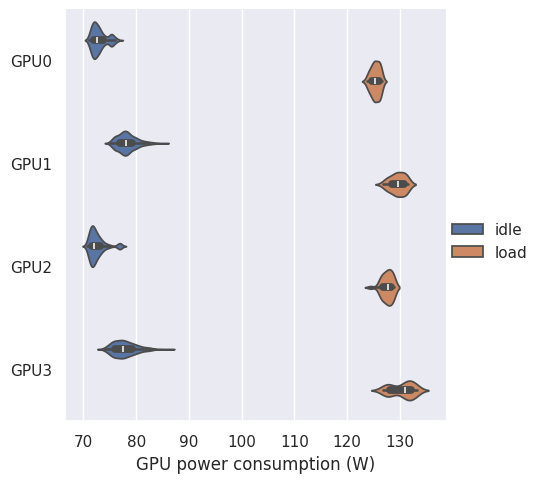

In [33]:
idle_and_load =  pd.concat([idle,load])
g = sns.catplot(data=idle_and_load, y='domain', x="SMI_power.draw", kind="violin", hue='label')
#g = sns.catplot(data=idle_and_load, y='domain', x="SMI_power.draw-norm", kind="violin", hue='label')
t = g.set_axis_labels("GPU power consumption (W)", "")
g.legend.set_title('')

plt.gcf().savefig('figures/MIG-static-dyn-A100.pdf', bbox_inches='tight')

10.771428571428572 52.53999999999999


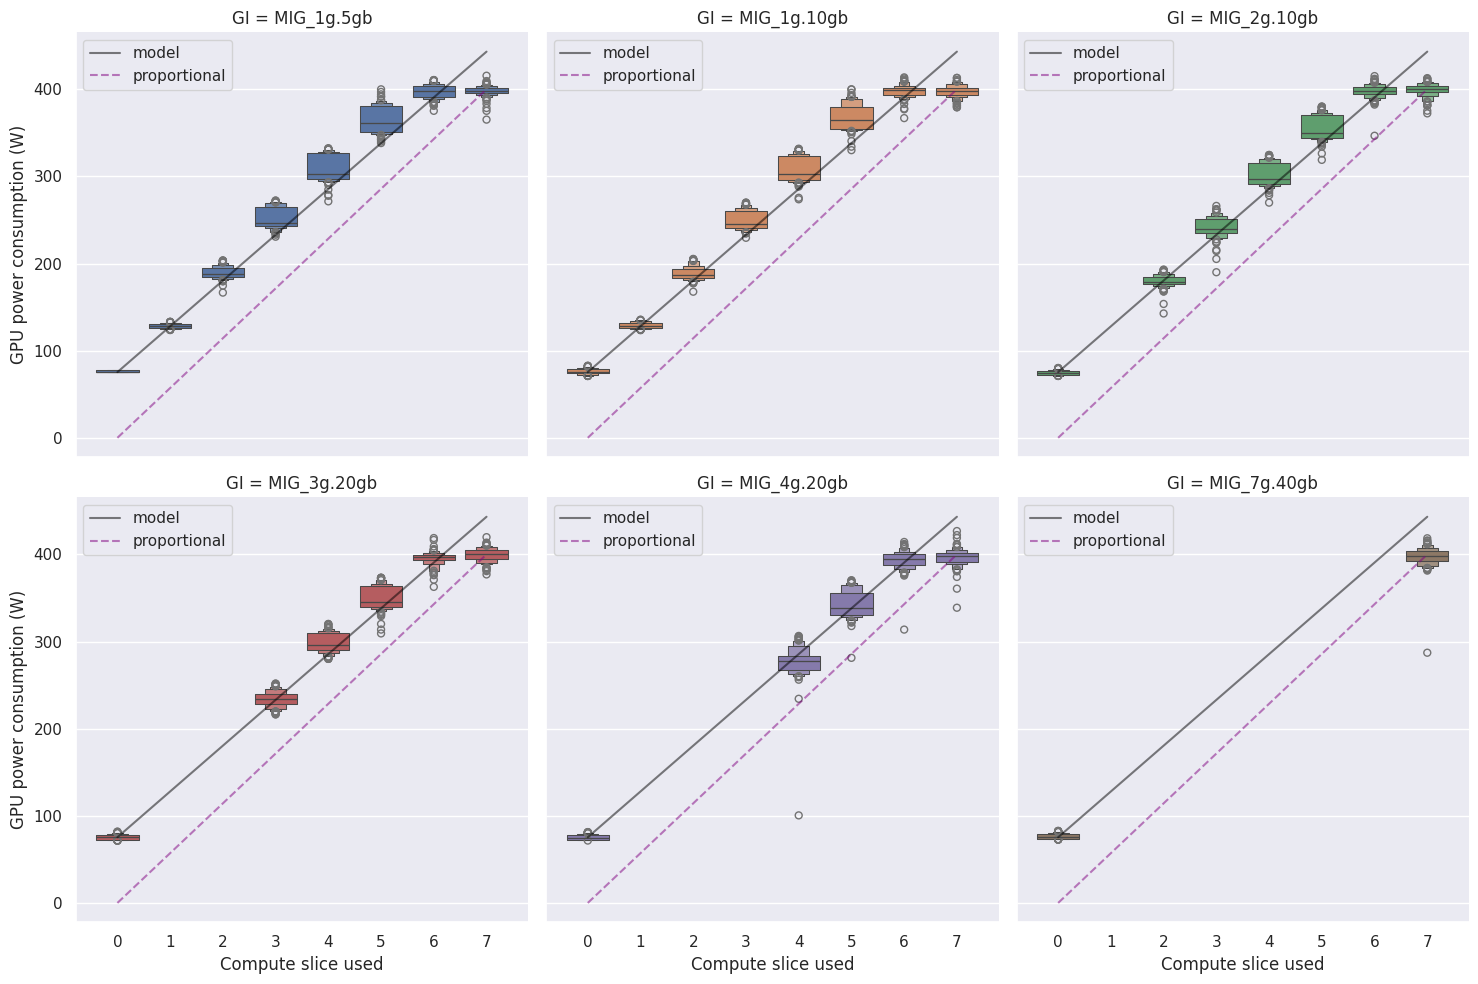

In [66]:
static = idle_value / compute_total
dynamic = (load_value - idle_value)
print(static, dynamic)

model = {'compute':[], 'model':[], 'proportionate':[]}
for i in range (8): 
    model['compute'].append(i)
    model['model'].append(idle_value + (dynamic*i))
    model['proportionate'].append((400/compute_total*i))
model_df = pd.DataFrame.from_dict(model)

g = sns.catplot(data=dataset_domain_pure, x='compute', y='SMI_power.draw', hue='CI', kind="boxen", col='GI', col_wrap=3, sharey=True)
g.set_axis_labels("Compute slice used", "GPU power consumption (W)")
index=0
for ax in g.axes:
    sns.lineplot(data=model_df, x="compute", y="model", ax=ax, color='black', linestyle='-', label='model', alpha=0.5)
    sns.lineplot(data=model_df, x="compute", y="proportionate", ax=ax, color='purple',  linestyle='--', alpha=0.5, label='proportional')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(labels=labels[-2:], handles=handles[-2:])
    index+=1

g.legend.remove()
plt.gcf().savefig('figures/MIG-GI-power-A100-models.pdf', bbox_inches='tight')

# Graph time H100

In [17]:
sns.color_palette("Set2")
sns.set_theme(style="darkgrid")

In [18]:
df = pd.read_csv('../data/250210-mig-muva-2xH100-burn300.csv')
df.reset_index(inplace=True)

drop_everything_before_measure = 'MIG_1g.12gb|1g.12gb|idle'

timestamp_decrease = df.timestamp.diff() < 0
restart = timestamp_decrease[timestamp_decrease].index.values
range_start = df.loc[df['measure'] == drop_everything_before_measure].iloc[0].values[0].astype(int)
frames = []
for range_end in restart:
    if range_start>0:
        frames.append(df[range_start:range_end].pivot(index=['timestamp','domain'], columns='metric', values='measure').reset_index())
    range_start = range_end
frames.append(df[range_start:].pivot(index=['timestamp','domain'], columns='metric', values='measure').reset_index())

dataset = pd.concat(frames)
dataset.set_index(['timestamp','domain', 'CONST_context'], inplace=True)
dataset_keys = list(dataset.keys())
if 'SMI_PSTATE' in dataset_keys: dataset_keys.remove('SMI_PSTATE')
if 'SMI_pstate' in dataset_keys: dataset_keys.remove('SMI_pstate')
dataset = dataset.astype({key:'float' for key in dataset_keys})
dataset.reset_index(inplace=True)

In [19]:
dataset_domain = dataset.drop(dataset.loc[dataset['domain'].isin(['GPU-X', 'global'])].index)
dataset_domain = dataset_domain.join(dataset_domain['CONST_context'].str.split('|', expand=True).rename(columns={0:'GI', 1:'CI', 2:'noise'}))
dataset_domain['wrk'] = dataset_domain['noise'].apply(lambda x: 0 if x == 'idle' else int(x) + 1)
dataset_domain['compute'] = dataset_domain.apply(lambda x: 0 if x['noise'] == 'idle' else (int(x['noise']) + int(re.match(r"^\d+", x['CI']).group())),  axis=1)
dataset_domain = dataset_domain.drop(dataset_domain.loc[dataset_domain['timestamp'] > 180 ].index)
dataset_domain = dataset_domain.drop(dataset_domain.loc[dataset_domain['timestamp'] < 30 ].index)
dataset_domain_pure = dataset_domain.drop(dataset_domain[dataset_domain.CI.str.contains("c.")].index)
dataset_domain['GI'].unique()

array(['MIG_1g.12gb', 'MIG_1g.24gb', 'MIG_2g.24gb', 'MIG_3g.47gb',
       'MIG_4g.47gb', 'MIG_7g.94gb'], dtype=object)

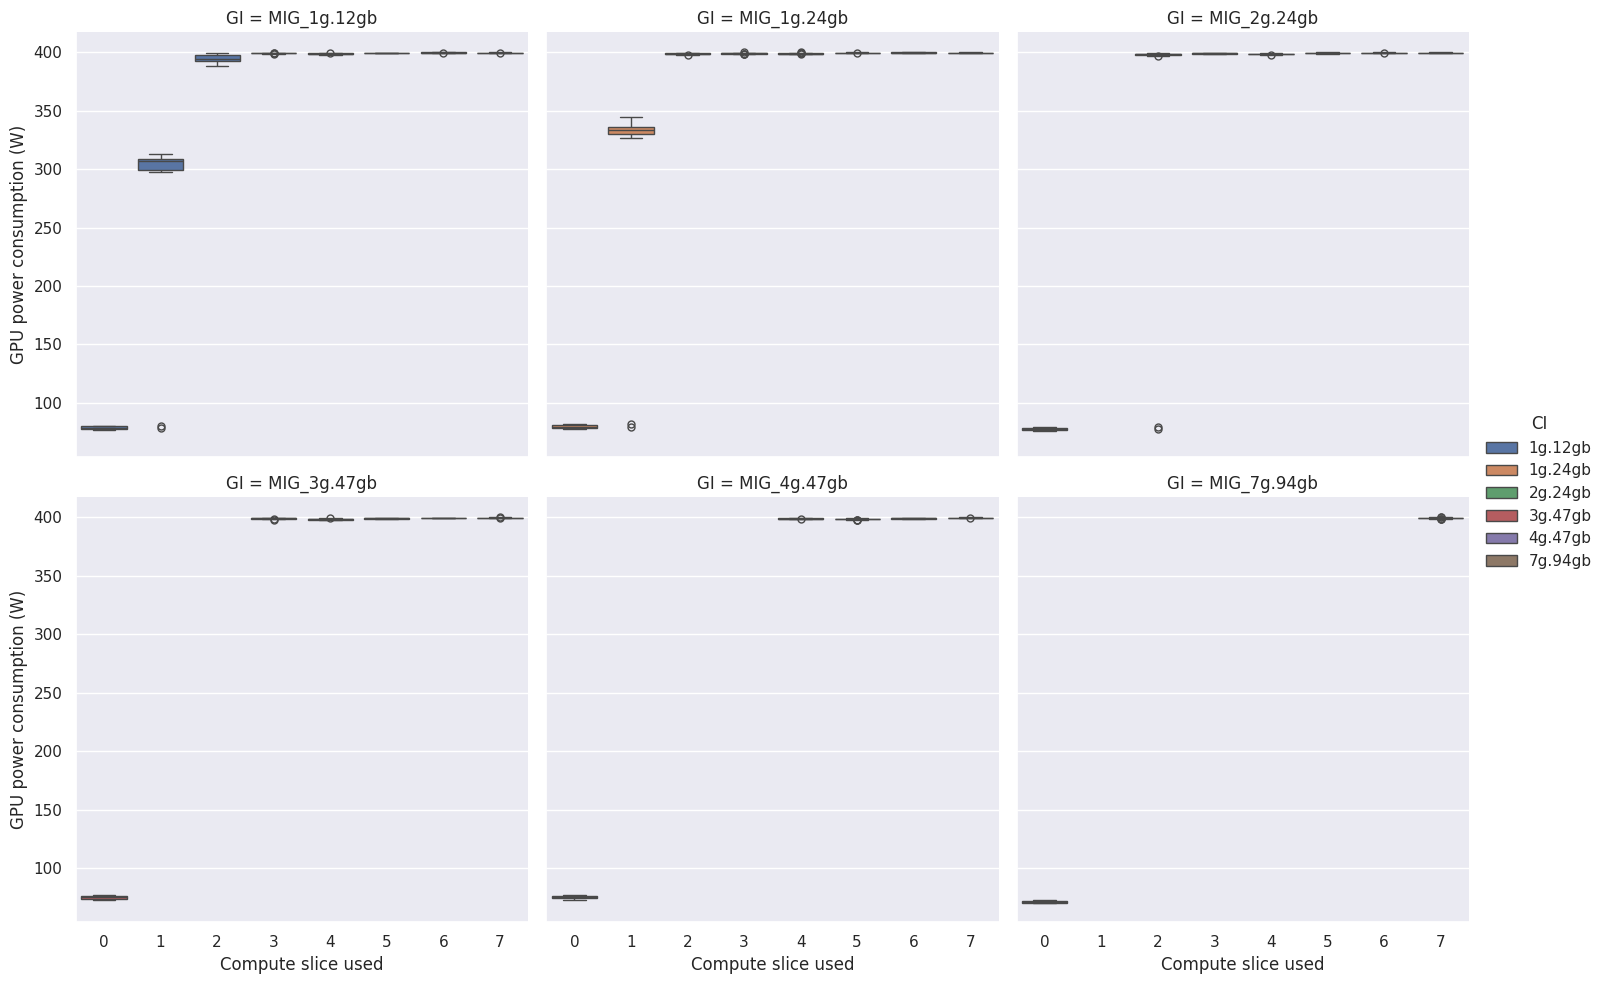

In [20]:
#sns.catplot(data=dataset_domain, x='timestamp', y='SMI_power.draw', hue='domain', col='CONST_context', col_wrap=7)
g = sns.catplot(data=dataset_domain_pure, x='compute', y='SMI_power.draw', hue='CI', col='GI', kind='box', col_wrap=3, sharey=True)
g.set_axis_labels("Compute slice used", "GPU power consumption (W)")
plt.gcf().savefig('figures/GI-power-H100.pdf', bbox_inches='tight')

In [14]:
gi_df['CONST_context'].unique()

array(['MIG_7g.94gb|1c.7g.94gb|idle', 'MIG_7g.94gb|1c.7g.94gb|0',
       'MIG_7g.94gb|2c.7g.94gb|idle', 'MIG_7g.94gb|2c.7g.94gb|0',
       'MIG_7g.94gb|3c.7g.94gb|idle', 'MIG_7g.94gb|3c.7g.94gb|0',
       'MIG_7g.94gb|4c.7g.94gb|idle', 'MIG_7g.94gb|4c.7g.94gb|0',
       'MIG_7g.94gb|7g.94gb|idle', 'MIG_7g.94gb|7g.94gb|0'], dtype=object)

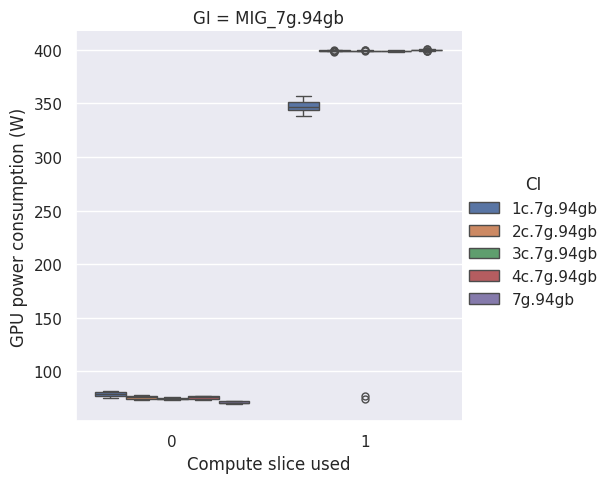

In [21]:
gi_label = 'MIG_7g.94gb'

gi_df = dataset_domain.loc[dataset_domain['GI'] == gi_label]

g = sns.catplot(data=gi_df, x='wrk', y='SMI_power.draw', col='GI', hue='CI', kind='box')
g.set_axis_labels("Compute slice used", "GPU power consumption (W)")

plt.gcf().savefig('figures/CI-power-H100.pdf', bbox_inches='tight')

In [22]:
compute_total = 7

In [23]:
idle = dataset_domain.loc[dataset_domain['noise'] == 'idle']
idle["SMI_power.draw-norm"] = idle["SMI_power.draw"] / compute_total
idle['label'] = 'idle'
# g = sns.catplot(data=idle, y='domain', x="SMI_power.draw", kind="violin")
print(np.average(idle["SMI_power.draw"]), np.median(idle["SMI_power.draw"]))
idle_value = np.median(idle["SMI_power.draw"])

77.59257653061223 78.025


/tmp/ipykernel_73597/3194054711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idle["SMI_power.draw-norm"] = idle["SMI_power.draw"] / compute_total
/tmp/ipykernel_73597/3194054711.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idle['label'] = 'idle'


In [24]:
load = dataset_domain.loc[(dataset_domain['noise'] == '0') & (dataset_domain['GI'] == 'MIG_1g.12gb')]
load["SMI_power.draw-norm"] = load["SMI_power.draw"] - idle_value
load['label'] = 'load'
# g = sns.catplot(data=load, y='domain', x="SMI_power.draw", kind="violin")
print(np.average(load["SMI_power.draw"]), np.median(load["SMI_power.draw"]))
load_value = np.median(load["SMI_power.draw"])

298.065 306.605


/tmp/ipykernel_73597/1899648131.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  load["SMI_power.draw-norm"] = load["SMI_power.draw"] - idle_value
/tmp/ipykernel_73597/1899648131.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  load['label'] = 'load'


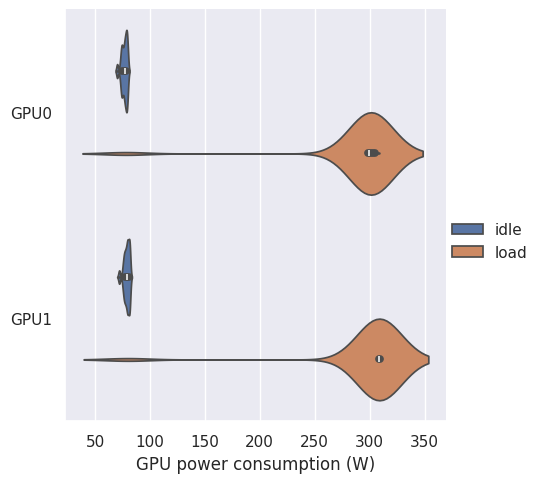

In [26]:
idle_and_load =  pd.concat([idle,load])
g = sns.catplot(data=idle_and_load, y='domain', x="SMI_power.draw", kind="violin", hue='label')
#g = sns.catplot(data=idle_and_load, y='domain', x="SMI_power.draw-norm", kind="violin", hue='label')
g.set_axis_labels("GPU power consumption (W)", "")
g.legend.set_title('')

plt.gcf().savefig('figures/MIG-static-dyn-H100.pdf', bbox_inches='tight')

11.146428571428572 228.58


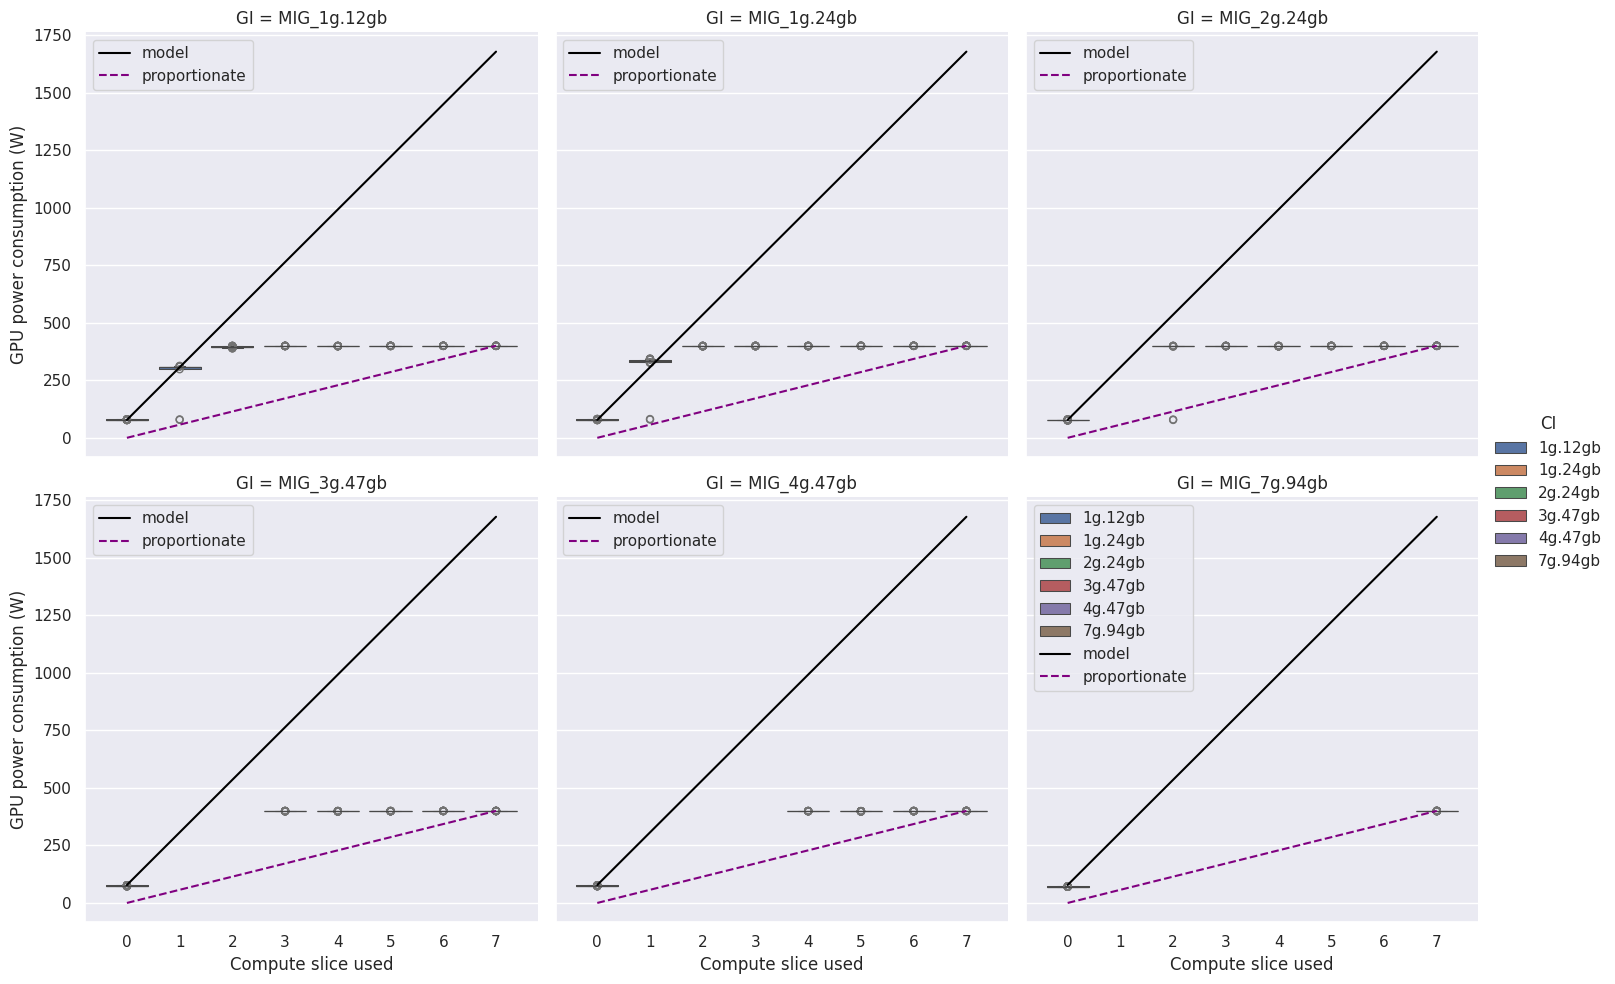

In [30]:
static = idle_value / compute_total
dynamic = (load_value - idle_value)
print(static, dynamic)

model = {'compute':[], 'model':[], 'proportionate':[]}
for i in range (8): 
    model['compute'].append(i)
    model['model'].append(idle_value + (dynamic*i))
    model['proportionate'].append((400/compute_total*i))
model_df = pd.DataFrame.from_dict(model)

g = sns.catplot(data=dataset_domain_pure, x='compute', y='SMI_power.draw', hue='CI', kind="boxen", col='GI', col_wrap=3, sharey=True)
g.set_axis_labels("Compute slice used", "GPU power consumption (W)")
for ax in g.axes:
    sns.lineplot(data=model_df, x="compute", y="model",ax=ax, color='black', label='model')
    sns.lineplot(data=model_df, x="compute", y="proportionate",ax=ax, color='purple', linestyle='--', label='proportionate')